## Классификация элементов ПСХЭ Менделеева на металлы и неметаллы

Дана таблица химических элементов и их электронная конфигурация. В последних двух столбцах указано количество валентных электронов `Nvalence` и метка `Metal` (1 - Ме, 0 - НеМе). Используя алгоритм случайного леса, решим задачу бинарной классификации химических элементов, различая их по:

- Электронной конфигурации
- Количеству валентных электронов и суммарному числу электронов.

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [85]:
def visualise_classifier_2d(model, X, y, ax=None, cmap='rainbow'):
    """
    This function plots the training points and fits the model to the data. 
    It creates a grid of points in the feature space, predicts the class for 
    each point, and visualizes the decision boundary using contour plots.

    Parameters:
    - model: Classification model with fit and predict methods.
    - X: 2D array of shape (n_samples, 2) with feature data.
    - y: 1D array of shape (n_samples,) with class labels.
    - ax: Optional matplotlib axis.
    - cmap: Colormap.
    """
    
    ax = ax or plt.gca()

    # Plotting the points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Fitting the points and labels to the estimator
    model.fit(X, y)
    # Creating X and Y 2D-grids
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    # Merging the grids into one (X, Y) grid
    xy = np.c_[xx.ravel(), yy.ravel()]
    # Predicting the classes
    Z = model.predict(xy).reshape(xx.shape)

    # Creating a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

In [87]:
# additional imports 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [89]:
# Reading the data
data = pd.read_csv('elements.csv', sep='\t')
y = data['Metal'].values
electron_columns = data.columns[2:-2]
X1 = data.loc[:, electron_columns].values
data['TotalElectrons'] = data.loc[:, electron_columns].sum(axis=1)
X2 = data[['Nvalence', 'TotalElectrons']].values

In [91]:
# Splitting the data into training and testing parts
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.5, random_state=42, stratify=y)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.5, random_state=42, stratify=y)

In [93]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_name, **rf_kwargs):
    model = RandomForestClassifier(random_state=42, **rf_kwargs)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} accuracy: {accuracy:.2f}")
    return model, y_pred


model1, y_pred1 = train_and_evaluate_model(
    X1_train, y1_train, X1_test, y1_test,
    "Classifier 1 (electron configuration)", 
    n_estimators=100, max_depth=5
)
model2, y_pred2 = train_and_evaluate_model(
    X2_train, y2_train, X2_test, y2_test,
    "Classifier 2 (N_valence, TotalElectrons)", 
    n_estimators=100, max_depth=5
)

Classifier 1 (electron configuration) accuracy: 0.86
Classifier 2 (N_valence, TotalElectrons) accuracy: 0.83


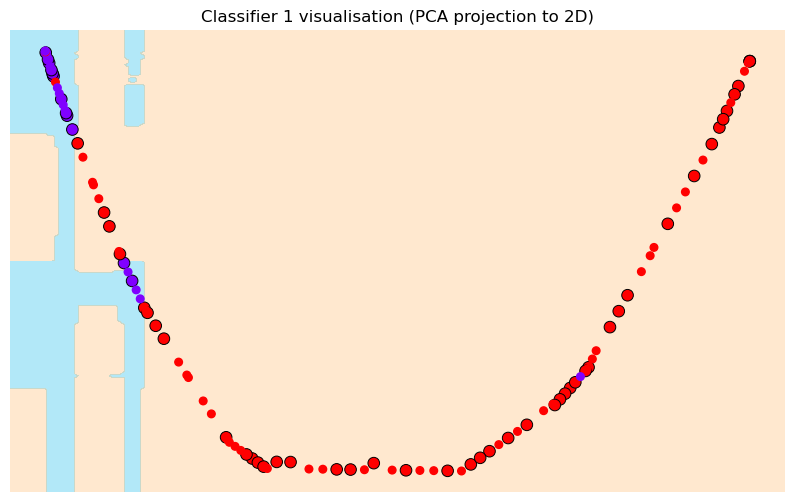

In [97]:
# A visualisation of the classifier 1 with PCA (18 params to 2D-plot)
pca = PCA(n_components=2, random_state=42)
X1_train_2d = pca.fit_transform(X1_train)
X1_test_2d = pca.transform(X1_test)

vis_rf1 = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=4)
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
visualise_classifier_2d(vis_rf1, X1_train_2d, y1_train, ax=ax1)
y1_pred_vis = vis_rf1.predict(X1_test_2d)
ax1.scatter(
    X1_test_2d[:, 0], X1_test_2d[:, 1], s=70, 
    c=y1_pred_vis, edgecolor='black', 
    cmap='rainbow', marker='o', linewidth=0.7
)
plt.title("Classifier 1 visualisation (PCA projection to 2D)")
plt.show()

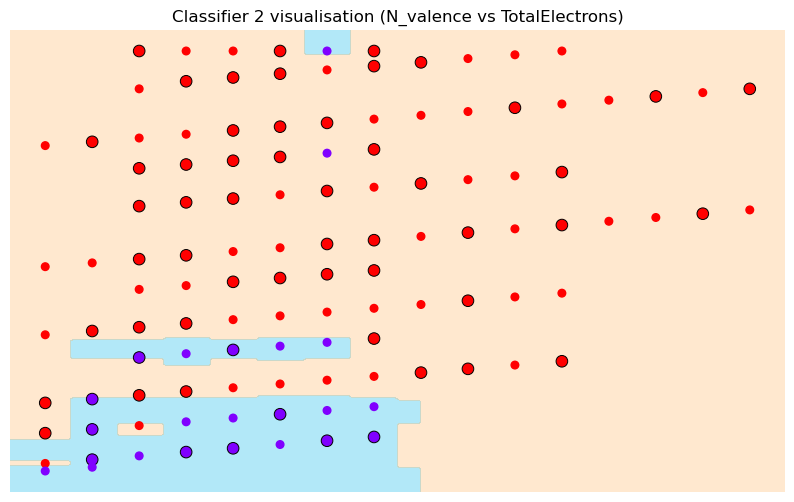

In [99]:
# Visualising the classifier 2
vis_rf2 = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=4)
plt.figure(figsize=(10, 6))
ax2 = plt.gca()
visualise_classifier_2d(vis_rf2, X2_train, y2_train, ax=ax2)
y2_pred_vis = vis_rf2.predict(X2_test)
ax2.scatter(X2_test[:, 0], X2_test[:, 1], s=70, c=y2_pred_vis, edgecolor='black', cmap='rainbow', marker='o', linewidth=0.7)
plt.title("Classifier 2 visualisation (N_valence vs TotalElectrons)")
plt.show()